# Experiments with eFEL and DEAP

In [1]:
import efel
import numpy as np
from quantities import mV

We are going to fit the AdEx model to a recording from a NEURON model of a L5 pyramidal neuron

In [2]:
data_original_model = np.loadtxt("L5_TTPC1_cADpyr232_1/python_recordings/soma_voltage_step1.dat")

In [3]:
time_orig, voltage_orig = data_original_model.T

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
def plot(times, vm, label=None):
    if label is None:
        plt.plot(times, vm)
    else:
        plt.plot(times, vm, label=label)
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane potential (mV)")

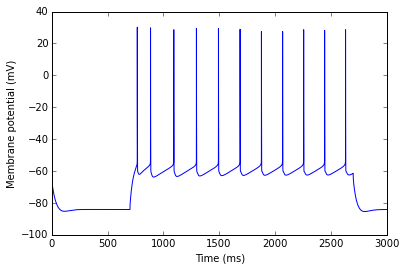

In [6]:
plot(time_orig, voltage_orig)

## Experiment with features

We are going to construct the error function using features extracted from the membrane potential trace and spike times using the [eFEL](http://bluebrain.github.io/eFEL/index.html) library.

In [7]:
def features(time, voltage, stim_limits, feature_names):
    start, end = stim_limits
    traces = [{'T': time, 'V': voltage, 'stim_start': [start], 'stim_end': [end]}]
    return efel.getFeatureValues(traces, feature_names)

In [8]:
features_original_model = features(time_orig, voltage_orig, (700, 2700),
                                   ['AP_amplitude', 'voltage_base', 'inv_time_to_first_spike', 'inv_first_ISI',
                                    'Spikecount', 'AHP_depth', 'AHP_time_from_peak'])

In [9]:
for trace_results in features_original_model:
    # trace_result is a dictionary, with as keys the requested eFeatures
    for feature_name, feature_values in trace_results.items():
        print("%s: %s" % (feature_name, ', '.join([str(x) for x in feature_values])))

AHP_time_from_peak: 18.3, 28.6, 29.8, 30.3, 30.7, 30.9, 31.0, 31.1, 31.1, 31.1, 31.1
AP_amplitude: 81.5437389021, 81.2920764068, 79.0358741728, 80.632283557, 80.4897410551, 81.5640124012, 78.7547618917, 78.6477627325, 79.0617444436, 78.4025297162, 81.7544523757
inv_time_to_first_spike: 15.197568389
voltage_base: -84.136625486
AHP_depth: 22.0301376167, 20.3554446575, 20.7302351123, 21.035748625, 21.2414029346, 21.3815948063, 21.4786448943, 21.5469639876, 21.5960152492, 21.6319214565, 21.6586806342
Spikecount: 11
inv_first_ISI: 8.43170320405


In [10]:
features_original_model

[{'AHP_depth': array([ 22.03013762,  20.35544466,  20.73023511,  21.03574862,
          21.24140293,  21.38159481,  21.47864489,  21.54696399,
          21.59601525,  21.63192146,  21.65868063]),
  'AHP_time_from_peak': array([ 18.3,  28.6,  29.8,  30.3,  30.7,  30.9,  31. ,  31.1,  31.1,
          31.1,  31.1]),
  'AP_amplitude': array([ 81.5437389 ,  81.29207641,  79.03587417,  80.63228356,
          80.48974106,  81.5640124 ,  78.75476189,  78.64776273,
          79.06174444,  78.40252972,  81.75445238]),
  'Spikecount': array([11]),
  'inv_first_ISI': array([ 8.4317032]),
  'inv_time_to_first_spike': array([ 15.19756839]),
  'voltage_base': array([-84.13662549])}]

## Setup AdEx simulation

In [11]:
import pyNN.nest as sim

In [12]:
def setup_simulation(sim):
    sim.setup(timestep=0.1)
    hyp_amp, step_amp = (-0.247559, (0.55425, 0.6004375, 0.646625))
    cell = sim.Population(1, sim.EIF_cond_exp_isfa_ista(i_offset=hyp_amp))
    cell.record(('spikes', 'v'))
    stim = sim.DCSource(start=700, stop=2700, amplitude=step_amp[0])
    stim.inject_into(cell)
    return cell

In [13]:
cell = setup_simulation(sim)

/home/docker/env/neurosci/local/lib/python2.7/site-packages/nest/lib/hl_api_helper.py:61: UserWarning: 
DivergentConnect is deprecated and will be removed in a future version of NEST.
Please use Connect instead!
For details, see http://www.nest-simulator.org/connection_management                       


In [14]:
def run(sim, cell, parameters):
    sim.reset()
    cell.set(**parameters)
    sim.run(3000.0)
    data = cell.get_data(clear=True).segments[0]
    vm = data.filter(name='v')[0]
    spike_times = data.spiketrains[0]
    return vm, spike_times

In [15]:
vm, spike_times = run(sim, cell, {'tau_m': 20.0, 'v_rest': -70.0})

In [16]:
spike_indices = (spike_times/vm.sampling_period).magnitude.astype(int)
vm[spike_indices] = 0.0*mV

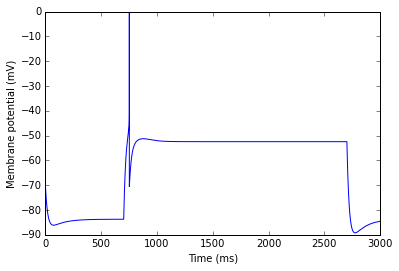

In [17]:
plot(vm.times, vm)

In [18]:
features_adexp = features(vm.times, vm, (700, 2700),
                          ['voltage_base', 'inv_time_to_first_spike', 'inv_first_ISI',
                           'Spikecount', 'AHP_depth', 'AHP_time_from_peak'])

In [19]:
for trace_results in features_adexp:
    # trace_result is a dictionary, with as keys the requested eFeatures
    for feature_name, feature_values in trace_results.items():
        if feature_values is None:
            print "%s: error" % feature_name
        else:
            print "%s: %s" % (feature_name, ', '.join([str(x) for x in feature_values]))

AHP_time_from_peak: 0.1
inv_time_to_first_spike: 19.4174757281
voltage_base: -83.7270313513
AHP_depth: 13.2187737193
Spikecount: 1
inv_first_ISI: 0.0


## Configure fitting tool (DEAP)

In [20]:
import deap
import deap.gp
import deap.benchmarks
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [21]:
import random
random.seed(1)

In [22]:
target_features = ['voltage_base', 'inv_time_to_first_spike', 'inv_first_ISI', 'Spikecount', 'AHP_depth']
reference_data = dict((k, v) for k, v in features_original_model[0].items() if k in target_features)

In [23]:
# Population size
POP_SIZE = 100
# Number of offspring in every generation
OFFSPRING_SIZE = 100

# Number of generations
NGEN = 100

# The parent and offspring population size are set the same
MU = OFFSPRING_SIZE
LAMBDA = OFFSPRING_SIZE
# Crossover probability
CXPB = 0.7
# Mutation probability, should sum to one together with CXPB
MUTPB = 0.3

# Eta parameter of cx and mut operators
ETA = 10.0

In [24]:
parameters = {'tau_refrac': [0.1, 10.0], 'a': [0.0, 50.0], 'tau_m': [1.0, 50.0],
              'cm': [0.1, 10.0], 'delta_T': [0.1, 10.0], 'v_thresh': [-70.0, -41.0],
              'b': [0.0, 1.0], 'v_reset': [-80.0, -50.0], 'tau_w': [10.0, 1000.0],
              'v_rest': [-80.0, -50.0]}
parameter_names = parameters.keys()
parameter_names.sort()

In [25]:
IND_SIZE = len(parameters)
LOWER = [parameters[name][0] for name in parameter_names]
UPPER = [parameters[name][1] for name in parameter_names]

In [26]:
SELECTOR = "NSGA2"
creator.create("Fitness", base.Fitness, weights=[-1.0] * len(target_features))
creator.create("Individual", list, fitness=creator.Fitness)

In [27]:
def uniform(lower_list, upper_list, dimensions):
    """Fill array """

    if hasattr(lower_list, '__iter__'):
        return [random.uniform(lower, upper) for lower, upper in
                zip(lower_list, upper_list)]
    else:
        return [random.uniform(lower_list, upper_list)
                for _ in range(dimensions)]

In [28]:
toolbox = base.Toolbox()
toolbox.register("uniformparams", uniform, LOWER, UPPER, IND_SIZE)
toolbox.register(
    "Individual",
    tools.initIterate,
    creator.Individual,
    toolbox.uniformparams)
toolbox.register("population", tools.initRepeat, list, toolbox.Individual)

In [29]:
def calc_errors(sim_data, reference_data):
    errors = []
    for k in sim_data:
        a = sim_data[k]
        b = reference_data[k]
        assert b is not None, "reference_data contains None: %s" % k
        if a is None: # missing features
            err = 10  # penalty should be defined elsewhere, and depend on feature
        elif isinstance(b, (int, float)):
            a = a[0]
            err = abs(a - b)
        else:
            L = min(len(a), len(b))
            err = np.abs(a[:L] - b[:L]).mean()
        errors.append(err)
    return errors

In [30]:
def build_evaluate(cell, reference_data):
    def evaluate(individual):
        parameters = dict((k,v) for k,v in zip(parameter_names, individual))
        try:
            vm, spike_times = run(sim, cell, parameters)
        except Exception as err:
            # log error message
            return [100]*len(reference_data)
        # add fake spikes
        spike_indices = (spike_times/vm.sampling_period).magnitude.astype(int)
        vm[spike_indices] = 0.0*mV
        feature_names = reference_data.keys()
        features_adexp = features(vm.times, vm, (700, 2700), feature_names)
        return calc_errors(features_adexp[0], reference_data)
    return evaluate

In [31]:
evaluate = build_evaluate(cell, reference_data)

In [32]:
test_params = uniform(LOWER, UPPER, IND_SIZE)

In [33]:
test_params

[6.718212205620061,
 0.8474337369372327,
 7.661368727868479,
 2.6251833548202748,
 25.276319267505105,
 4.549961541408507,
 655.0770429955353,
 -56.338299465934604,
 -77.18421239677295,
 -69.17792318086181]

In [34]:
print(reference_data.keys())
evaluate(test_params)

['AHP_depth', 'inv_first_ISI', 'voltage_base', 'inv_time_to_first_spike', 'Spikecount']
/home/docker/env/neurosci/local/lib/python2.7/site-packages/efel/api.py:319: RuntimeWarning: Error while calculating feature AHP_depth: 
 Two spikes required for calculation of all_ISI_values.

Feature [all_ISI_values] is missing

Voltage never goes below or above threshold in spike detection.

 At least one spike required for calculation of min_AHP_indices.

Feature [min_AHP_values] is missing



[10, 11.0, 15.197568389033368, 6.2375997954149796, 8.4317032040453004]

In [35]:
toolbox.register("evaluate", evaluate)

In [36]:
toolbox.register(
    "mate",
    deap.tools.cxSimulatedBinaryBounded,
    eta=ETA,
    low=LOWER,
    up=UPPER)
toolbox.register("mutate", deap.tools.mutPolynomialBounded, eta=ETA,
                 low=LOWER, up=UPPER, indpb=0.1)

In [37]:
toolbox.register(
    "select",
    tools.selNSGA2)

## Run the fitting procedure

In [38]:
pop = toolbox.population(n=MU)

In [ ]:
stats = [tools.Statistics(key=lambda ind: ind.fitness.values[i])
         for i in range(len(reference_data))]
mstats = tools.MultiStatistics(obj1=stats[0], obj2=stats[1], obj3=stats[2], obj4=stats[3], obj5=stats[4])
mstats.register("min", np.min, axis=0)

In [ ]:
pop, logbook = algorithms.eaMuPlusLambda(
        pop,
        toolbox,
        MU,
        LAMBDA,
        CXPB,
        MUTPB,
        NGEN,
        mstats,
        halloffame=None)

/home/docker/env/neurosci/local/lib/python2.7/site-packages/efel/api.py:319: RuntimeWarning: Error while calculating feature AHP_depth: 
 Two spikes required for calculation of all_ISI_values.

Feature [all_ISI_values] is missing

 One spike required for time_to_first_spike.

Feature [time_to_first_spike] is missing

Voltage never goes below or above threshold in spike detection.

 At least one spike required for calculation of min_AHP_indices.

Feature [min_AHP_values] is missing

/home/docker/env/neurosci/local/lib/python2.7/site-packages/efel/api.py:319: RuntimeWarning: Error while calculating feature AHP_depth: 
 Two spikes required for calculation of all_ISI_values.

Feature [all_ISI_values] is missing

 One spike required for time_to_first_spike.

Feature [time_to_first_spike] is missing

 Two spikes required for calculation of all_ISI_values.

Feature [all_ISI_values] is missing

Voltage never goes below or above threshold in spike detection.

 At least one spike required for ca

In [ ]:
type(pop[0])

In [ ]:
[ind.fitness.values for ind in pop[:5]]

In [ ]:
parameters = dict((k,v) for k,v in zip(parameter_names, pop[1]))
vm, spike_times = run(sim, cell, parameters)
spike_indices = (spike_times/vm.sampling_period).magnitude.astype(int)
vm[spike_indices] = 0.0*mV

In [ ]:
plot(vm.times, vm, label="AdExp")
plot(time_orig, voltage_orig, label="NEURON")
plt.legend()